In [1]:
import time
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Circle
from skimage.feature import blob_log
from skimage.filters import threshold_li
from skimage.morphology import remove_small_objects
from nd2reader import ND2Reader

In [2]:
# Directory with .nd2 files
path = 'data/20220908_K562_EVI1-GFP_ctrl_CTRL_Altius_PaintSHOP'

# use glob to get all .nd2 image files in path
img_files = sorted(glob.glob(path + '/*.nd2'))
img_files

['data/20220908_K562_EVI1-GFP_ctrl_CTRL_Altius_PaintSHOP/K562_ctrl_CTRL_central_offset_seq1_Atto647N_011.nd2',
 'data/20220908_K562_EVI1-GFP_ctrl_CTRL_Altius_PaintSHOP/K562_ctrl_CTRL_central_offset_seq1_Atto647N_012.nd2',
 'data/20220908_K562_EVI1-GFP_ctrl_CTRL_Altius_PaintSHOP/K562_ctrl_CTRL_central_offset_seq1_Atto647N_013.nd2',
 'data/20220908_K562_EVI1-GFP_ctrl_CTRL_Altius_PaintSHOP/K562_ctrl_CTRL_central_offset_seq1_Atto647N_014.nd2',
 'data/20220908_K562_EVI1-GFP_ctrl_CTRL_Altius_PaintSHOP/K562_ctrl_CTRL_central_offset_seq1_Atto647N_015.nd2',
 'data/20220908_K562_EVI1-GFP_ctrl_CTRL_Altius_PaintSHOP/K562_ctrl_CTRL_central_seq1_Atto647N_006.nd2',
 'data/20220908_K562_EVI1-GFP_ctrl_CTRL_Altius_PaintSHOP/K562_ctrl_CTRL_central_seq1_Atto647N_008.nd2',
 'data/20220908_K562_EVI1-GFP_ctrl_CTRL_Altius_PaintSHOP/K562_ctrl_CTRL_central_seq1_Atto647N_009.nd2',
 'data/20220908_K562_EVI1-GFP_ctrl_CTRL_Altius_PaintSHOP/K562_ctrl_CTRL_central_seq1_Atto647N_010.nd2',
 'data/20220908_K562_EVI1-GFP

# Background Correction

In [3]:
from skimage import restoration
from scipy import ndimage as ndi

def smoothed_background(img, r=100, smooth=True):
    # estimate background with (optional) smooting

    # smooth like ImageJ: https://imagej.nih.gov/ij/docs/menus/process.html#background
    if smooth:
        img = ndi.median_filter(ndi.maximum_filter(img, 3), 3)

    return restoration.rolling_ball(img, radius = r)

def subtract_background(img, r=100, smooth=True):

    if len(img.shape) == 2:
        background = smoothed_background(img, r, smooth)

    # do for each plane in 3d img (NOTE: can be very slow!)
    elif len(img.shape) == 3:
        background = np.zeros_like(img)
        for i in range(img.shape[0]):
            background[i] = smoothed_background(img[i], r, smooth)

    else:
        raise ValueError('image neither 2D nor 3D')

    return img-background

# Detect Spots & create df

In [4]:
combined_df = pd.DataFrame()

for img_file in img_files:
    # Load image
    with ND2Reader(img_file) as reader:
        reader.bundle_axes = 'czyx'
        img = np.array(reader[0])

    # Select only Atto647N channel and create max projection
    img_atto = img[1]
    atto_max = np.max(img_atto, axis=0)
    
    # Detect spots with Laplacian of Gaussian (LoG)
    blobs_log = blob_log(atto_max, max_sigma=5, num_sigma=10, threshold=40)
    blobs_log[:, 2] = blobs_log[:, 2] * np.sqrt(2 * np.log(2))
    
    # Get dapi image, segment via thresholding
    img_dapi = img[0]
    t = threshold_li(img_dapi)
    dapi_mask = img_dapi > t
    dapi_mask = remove_small_objects(dapi_mask)
    
    in_nucleus = []
    for y,x,s in blobs_log:

        # Get intensities at this xy point along z, find maximum, check if in dapi mask
        z_intensities = img_atto[:, int(y), int(x)]
        z = np.argmax(z_intensities)
        in_nucleus.append(dapi_mask[int(z), int(y), int(x)])

    # Only keep blobs that are in nucleus
    blobs_log = blobs_log[in_nucleus]

    # Background correction
    atto_max_subbg = subtract_background(atto_max)
    
    # Make df of spots intensity and fwhm
    intensities = []
    for y, x, r in blobs_log:
        intensities.append(atto_max_subbg[int(y), int(x)])
    df = pd.DataFrame()
    df['intensity'] = intensities
    df['fwhm'] = blobs_log[:,2] * 2
    df['file'] = img_file
    
    # NOTE: we add the volume of the cell for every spot here
    df['cells_volume'] = dapi_mask.sum()
    
    # Concatenate to combined_df
    combined_df = pd.concat([combined_df, df])

/usr/local/lib/python3.8/dist-packages/nd2reader/raw_metadata.py:187: UserWarning: Z-levels details missing in metadata. Using Z-coordinates instead.
  warnings.warn("Z-levels details missing in metadata. Using Z-coordinates instead.")


/usr/local/lib/python3.8/dist-packages/nd2reader/raw_metadata.py:187: UserWarning: Z-levels details missing in metadata. Using Z-coordinates instead.
  warnings.warn("Z-levels details missing in metadata. Using Z-coordinates instead.")


/usr/local/lib/python3.8/dist-packages/nd2reader/raw_metadata.py:187: UserWarning: Z-levels details missing in metadata. Using Z-coordinates instead.
  warnings.warn("Z-levels details missing in metadata. Using Z-coordinates instead.")


/usr/local/lib/python3.8/dist-packages/nd2reader/raw_metadata.py:187: UserWarning: Z-levels details missing in metadata. Using Z-coordinates instead.
  warnings.warn("Z-levels details missing in metadata. Using Z-coordinates instead.")


/usr/local/lib/python3.8/dist-packages/nd2reader/raw_metadata.py:187: UserWarning: Z-levels details missing in metadata. Using Z-coordinates instead.
  warnings.warn("Z-levels details missing in metadata. Using Z-coordinates instead.")


/usr/local/lib/python3.8/dist-packages/nd2reader/raw_metadata.py:187: UserWarning: Z-levels details missing in metadata. Using Z-coordinates instead.
  warnings.warn("Z-levels details missing in metadata. Using Z-coordinates instead.")


/usr/local/lib/python3.8/dist-packages/nd2reader/raw_metadata.py:187: UserWarning: Z-levels details missing in metadata. Using Z-coordinates instead.
  warnings.warn("Z-levels details missing in metadata. Using Z-coordinates instead.")


/usr/local/lib/python3.8/dist-packages/nd2reader/raw_metadata.py:187: UserWarning: Z-levels details missing in metadata. Using Z-coordinates instead.
  warnings.warn("Z-levels details missing in metadata. Using Z-coordinates instead.")


/usr/local/lib/python3.8/dist-packages/nd2reader/raw_metadata.py:187: UserWarning: Z-levels details missing in metadata. Using Z-coordinates instead.
  warnings.warn("Z-levels details missing in metadata. Using Z-coordinates instead.")


/usr/local/lib/python3.8/dist-packages/nd2reader/raw_metadata.py:187: UserWarning: Z-levels details missing in metadata. Using Z-coordinates instead.
  warnings.warn("Z-levels details missing in metadata. Using Z-coordinates instead.")


/usr/local/lib/python3.8/dist-packages/nd2reader/raw_metadata.py:187: UserWarning: Z-levels details missing in metadata. Using Z-coordinates instead.
  warnings.warn("Z-levels details missing in metadata. Using Z-coordinates instead.")


/usr/local/lib/python3.8/dist-packages/nd2reader/raw_metadata.py:187: UserWarning: Z-levels details missing in metadata. Using Z-coordinates instead.
  warnings.warn("Z-levels details missing in metadata. Using Z-coordinates instead.")


/usr/local/lib/python3.8/dist-packages/nd2reader/raw_metadata.py:187: UserWarning: Z-levels details missing in metadata. Using Z-coordinates instead.
  warnings.warn("Z-levels details missing in metadata. Using Z-coordinates instead.")


/usr/local/lib/python3.8/dist-packages/nd2reader/raw_metadata.py:187: UserWarning: Z-levels details missing in metadata. Using Z-coordinates instead.
  warnings.warn("Z-levels details missing in metadata. Using Z-coordinates instead.")


/usr/local/lib/python3.8/dist-packages/nd2reader/raw_metadata.py:187: UserWarning: Z-levels details missing in metadata. Using Z-coordinates instead.
  warnings.warn("Z-levels details missing in metadata. Using Z-coordinates instead.")


/usr/local/lib/python3.8/dist-packages/nd2reader/raw_metadata.py:187: UserWarning: Z-levels details missing in metadata. Using Z-coordinates instead.
  warnings.warn("Z-levels details missing in metadata. Using Z-coordinates instead.")


/usr/local/lib/python3.8/dist-packages/nd2reader/raw_metadata.py:187: UserWarning: Z-levels details missing in metadata. Using Z-coordinates instead.
  warnings.warn("Z-levels details missing in metadata. Using Z-coordinates instead.")


/usr/local/lib/python3.8/dist-packages/nd2reader/raw_metadata.py:187: UserWarning: Z-levels details missing in metadata. Using Z-coordinates instead.
  warnings.warn("Z-levels details missing in metadata. Using Z-coordinates instead.")


/usr/local/lib/python3.8/dist-packages/nd2reader/raw_metadata.py:187: UserWarning: Z-levels details missing in metadata. Using Z-coordinates instead.
  warnings.warn("Z-levels details missing in metadata. Using Z-coordinates instead.")


In [5]:
 combined_df

,intensity,fwhm,file,cells_volume
0,3417.927808,3.401407,data/20220908_K562_EVI1-GFP_ctrl_CTRL_Altius_P...,10444000
1,2365.101010,3.401407,data/20220908_K562_EVI1-GFP_ctrl_CTRL_Altius_P...,10444000
2,1082.781661,3.401407,data/20220908_K562_EVI1-GFP_ctrl_CTRL_Altius_P...,10444000
3,691.978721,3.401407,data/20220908_K562_EVI1-GFP_ctrl_CTRL_Altius_P...,10444000
4,394.539332,3.401407,data/20220908_K562_EVI1-GFP_ctrl_CTRL_Altius_P...,10444000
...,...,...,...,...
187,164.303846,2.354820,data/20220908_K562_EVI1-GFP_ctrl_CTRL_Altius_P...,12399758
188,166.057877,3.401407,data/20220908_K562_EVI1-GFP_ctrl_CTRL_Altius_P...,12399758
189,178.332738,2.354820,data/20220908_K562_EVI1-GFP_ctrl_CTRL_Altius_P...,12399758
190,116.081486,5.494580,data/20220908_K562_EVI1-GFP_ctrl_CTRL_Altius_P...,12399758


In [6]:
combined_df = combined_df.reset_index(drop=True)

In [7]:
def source(p):
    source=[]
    if 'central_offset' in p:
        source = 'PaintShop central+offset'
    if 'central_seq1' in p:
        source = 'PaintShop central'
    if 'CTRL_seq1' in p:
        source = 'Altius'
    if 'ctrl_seq1' in p:
        source = 'Negative Control'
    return source


In [8]:
combined_df['Source'] = combined_df['file'].apply(source)
combined_df['Formamide'] = '1h FA'

In [9]:
combined_df
combined_df.to_csv("./combined_df_old.csv", index=False)

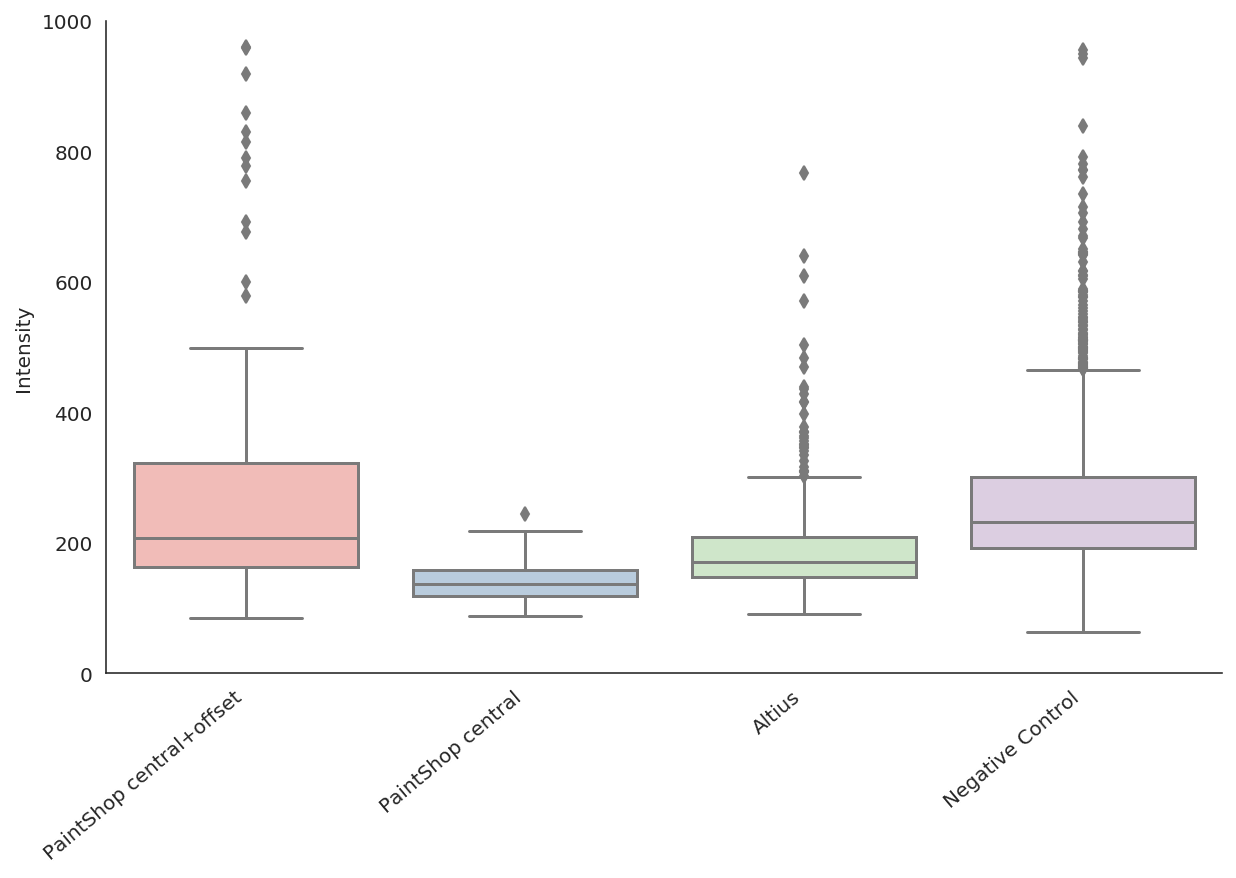

In [10]:
plt.figure(figsize = (10,6))
sns.set_style('white')
boxplot = sns.boxplot(x='Source', y='intensity', data=combined_df, palette='Pastel1', dodge=False)
boxplot.set_ylabel("Intensity")
boxplot.set(xlabel=None)
boxplot.set_xticklabels(boxplot.get_xticklabels(), rotation=40, ha="right")
boxplot.set_ylim(0, 1000)
sns.despine()
plt.show()

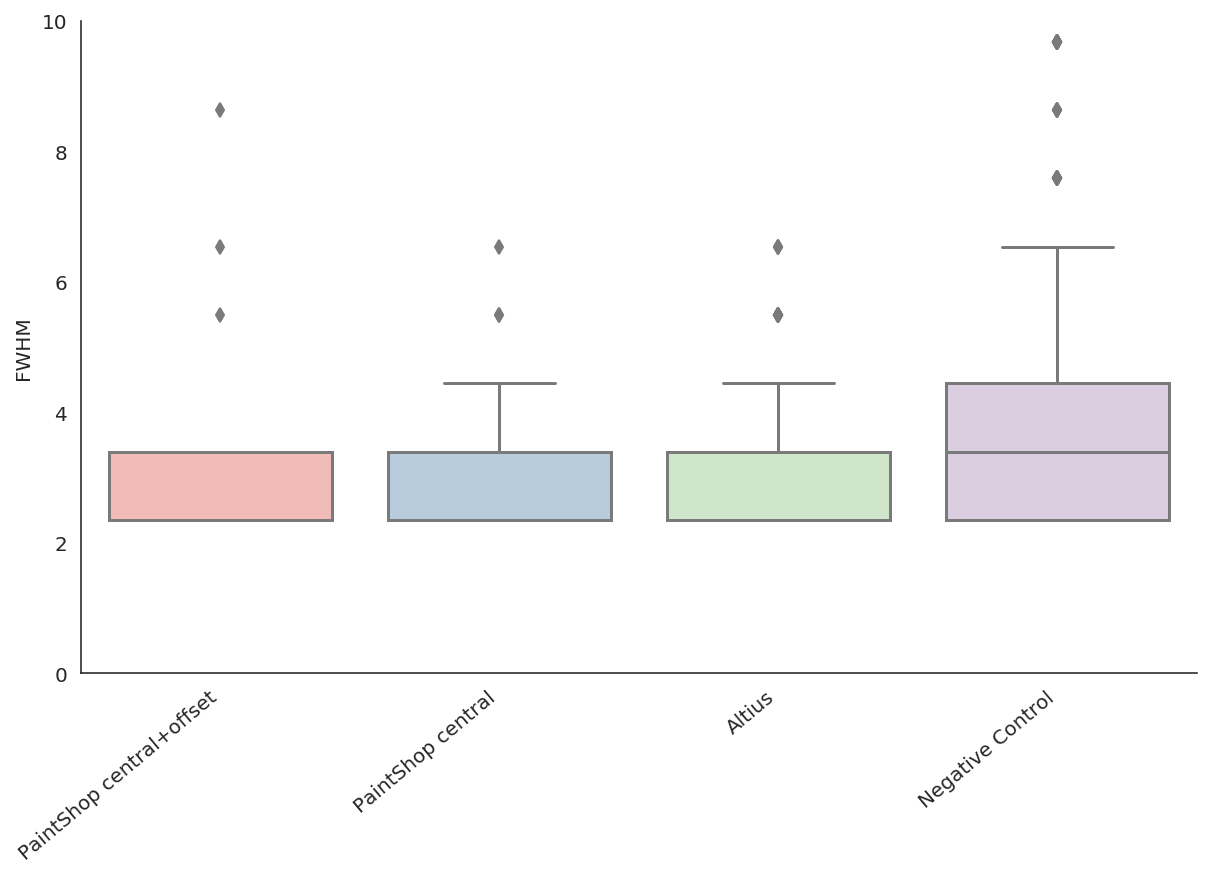

In [11]:
plt.figure(figsize = (10,6))
sns.set_style('white')
boxplot = sns.boxplot(x='Source', y='fwhm', data=combined_df, palette='Pastel1', dodge=False)
boxplot.set_ylabel("FWHM")
boxplot.set(xlabel=None)
boxplot.set_xticklabels(boxplot.get_xticklabels(), rotation=40, ha="right")
boxplot.set_ylim(0, 10)
sns.despine()
plt.show()

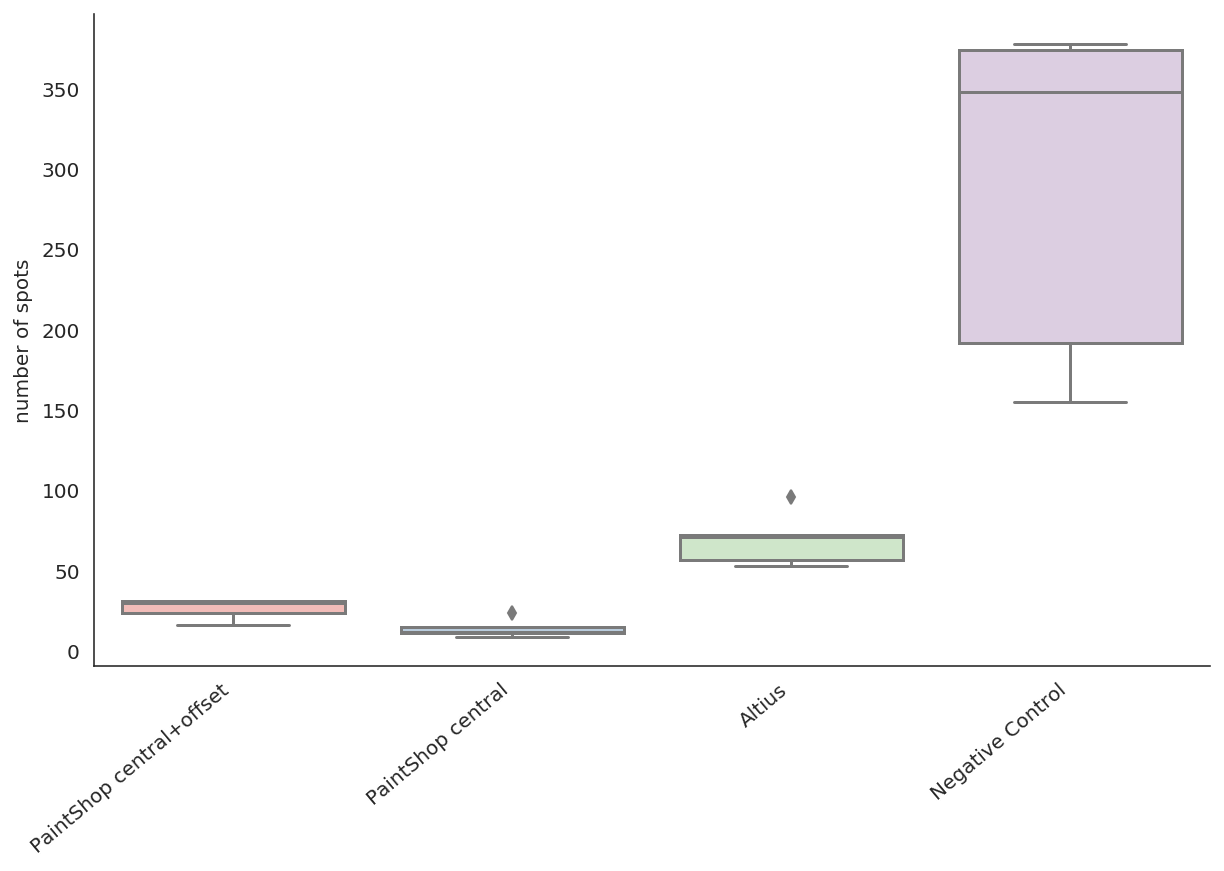

In [12]:
df_counts = combined_df.groupby('file')['Source'].describe()

plt.figure(figsize = (10,6))
sns.set_style('white')
boxplot = sns.boxplot(x='top', y='count', data=df_counts, palette='Pastel1', dodge=False)
boxplot.set_ylabel("number of spots")
boxplot.set(xlabel=None)
boxplot.set_xticklabels(boxplot.get_xticklabels(), rotation=40, ha="right")
# boxplot.set_ylim(0, 100)
sns.despine()
plt.show()

## Pairwise comparison with MultiComparison

In [13]:
from scipy.stats import mannwhitneyu
from statsmodels.stats.multicomp import MultiComparison

# init multi comparison
# freq has to be converted to int
mc = MultiComparison(df_counts.freq.astype(int), df_counts.top)

# do pairwise tests with MannWhitneyU, Holm correction
res, _, _ = mc.allpairtest(mannwhitneyu, method='holm')

# display results as table
res

group1,group2,stat,pval,pval_corr,reject
Altius,Negative Control,0.0,0.0079,0.0476,True
Altius,PaintShop central,20.0,0.0195,0.0596,False
Altius,PaintShop central+offset,25.0,0.0119,0.0596,False
Negative Control,PaintShop central,20.0,0.0195,0.0596,False
Negative Control,PaintShop central+offset,25.0,0.0119,0.0596,False
PaintShop central,PaintShop central+offset,1.5,0.0472,0.0596,False


## Old: multiple comparison by hand

In [14]:
# from scipy.stats import mannwhitneyu


# x = df_counts[df_counts.top == 'Paintshop central offset']['freq'].values.astype(int)
# y = df_counts[df_counts.top == 'Altius']['freq'].values.astype(int)

# mannwhitneyu(x, y)
#  x, y

In [15]:
# from itertools import combinations
# from statsmodels.stats.multitest import multipletests

# pvalues = []
# for k1, k2 in combinations(df_counts.top.unique(), 2):
#     x = df_counts[df_counts.top == k1]['freq'].values.astype(int)
#     y = df_counts[df_counts.top == k2]['freq'].values.astype(int)
#     pvalues.append(mannwhitneyu(x, y).pvalue)
# pvalues

# sig, pvalues_adj, _, _ = multipletests(pvalues)

# for k, s, pval in zip(combinations(df_counts.top.unique(), 2), sig, pvalues_adj):
#     print(f'{k}: {pval} {"*" if s else ""}')